In [26]:
from qiskit_aer import AerSimulator
from qiskit import *
import qiskit
import qiskit_superstaq as qss
import supermarq
import numpy as np 
import os

In [3]:
bitc = supermarq.bit_code.BitCode(3, 3, [1, 0, 1])
bitc_circuit = bitc.qiskit_circuit()
bitc_circuit.draw()

┌───┐                                                    ┌─┐     »
         q_0: ┤ X ├──■─────────────────■────────────────────■──────────┤M├─────»
              └───┘┌─┴─┐┌───┐┌─┐     ┌─┴─┐┌───┐   ┌─┐     ┌─┴─┐┌───┐   └╥┘     »
         q_1: ─────┤ X ├┤ X ├┤M├─|0>─┤ X ├┤ X ├───┤M├─|0>─┤ X ├┤ X ├────╫──────»
                   └───┘└─┬─┘└╥┘     └───┘└─┬─┘   └╥┘     └───┘└─┬─┘    ║      »
         q_2: ──■─────────■───╫────────■────■──────╫────────■────■──────╫──────»
              ┌─┴─┐┌───┐ ┌─┐  ║      ┌─┴─┐┌───┐┌─┐ ║      ┌─┴─┐┌───┐┌─┐ ║      »
         q_3: ┤ X ├┤ X ├─┤M├──╫──|0>─┤ X ├┤ X ├┤M├─╫──|0>─┤ X ├┤ X ├┤M├─╫──|0>─»
              ├───┤└─┬─┘ └╥┘  ║      └───┘└─┬─┘└╥┘ ║      └───┘└─┬─┘└╥┘ ║  ┌─┐ »
         q_4: ┤ X ├──■────╫───╫─────────────■───╫──╫─────────────■───╫──╫──┤M├─»
              └───┘       ║   ║                 ║  ║                 ║  ║  └╥┘ »
    m_mcm0: 2/════════════╩═══╩═════════════════╬══╬═════════════════╬══╬═══╬══»
                          1   0                 ║  ║                 ║  ║   ║  »
    m_mcm1: 2/══════════════════════════════════╩══╩═════════════════╬══╬═══╬══»
                                                1  0                 ║  ║   ║  »
    m_mcm2: 2/═══════════════════════════════════════════════════════╩══╬═══╬══»
                                                                     1  ║   ║  »
m_meas_all: 5/══════════════════════════════════════════════════════════╩═══╩══»
                                                                        0   4  »
«                            
«         q_0: ──────────────
«              ┌─┐        ┌─┐
«         q_1: ┤M├─|0>────┤M├
«              └╥┘ ┌─┐    └╥┘
«         q_2: ─╫──┤M├─────╫─
«               ║  └╥┘ ┌─┐ ║ 
«         q_3: ─╫───╫──┤M├─╫─
«               ║   ║  └╥┘ ║ 
«         q_4: ─╫───╫───╫──╫─
«               ║   ║   ║  ║ 
«    m_mcm0: 2/═╬═══╬═══╬══╬═
«               ║   ║   ║  ║ 
«    m_mcm1: 2/═╬═══╬═══╬══╬═
«               ║   ║   ║  ║ 
«    m_mcm2: 2/═╩═══╬═══╬══╬═
«               0   ║   ║  ║ 
«m_meas_all: 5/═════╩═══╩══╩═
«                   2   3  1

In [4]:
emulator = Aer.get_backend('aer_simulator_density_matrix')

In [8]:
qc = transpile(bitc_circuit, emulator)
job = execute(qc, emulator, shots=8192, memory=False)
data=job.result()
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [9]:
data = job.result()
data

Result(backend_name='aer_simulator', backend_version='0.13.0', qobj_id='', job_id='7205c1e4-3b4b-418e-9cea-87b83e350db6', success=True, results=[ExperimentResult(shots=8192, success=True, meas_level=2, data=ExperimentResultData(counts={'0x47f': 8192}), header=QobjExperimentHeader(creg_sizes=[['m_mcm0', 2], ['m_mcm1', 2], ['m_mcm2', 2], ['m_meas_all', 5]], global_phase=0.0, memory_slots=11, n_qubits=5, name='circuit-159', qreg_sizes=[['q', 5]], metadata={}), status=DONE, seed_simulator=3356641837, metadata={'time_taken': 0.070027509, 'num_bind_params': 1, 'parallel_state_update': 1, 'required_memory_mb': 1, 'input_qubit_map': [[4, 4], [3, 3], [2, 2], [1, 1], [0, 0]], 'method': 'density_matrix', 'device': 'CPU', 'num_qubits': 5, 'active_input_qubits': [0, 1, 2, 3, 4], 'num_clbits': 11, 'remapped_qubits': False, 'parallel_shots': 24, 'runtime_parameter_bind': False, 'max_memory_mb': 63964, 'noise': 'ideal', 'measure_sampling': False, 'batched_shots_optimization': False, 'fusion': {'applie

In [10]:
counts = job.result().get_counts()
print(counts)

{'10001 11 11 11': 8192}


In [13]:
score = bitc.score(counts)
print(score)

0.0


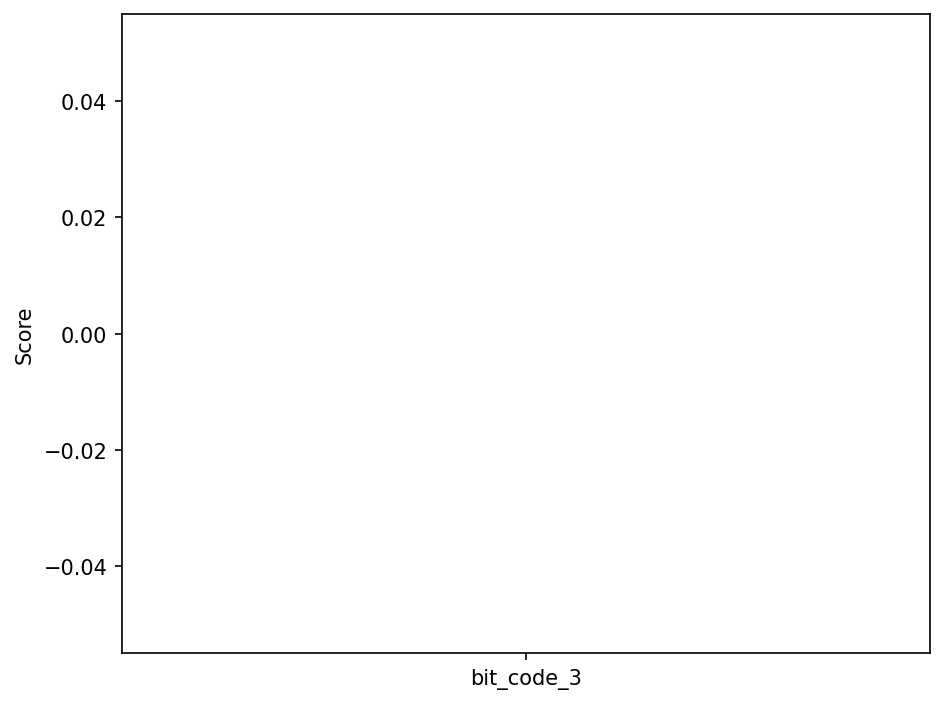

In [12]:
supermarq.plotting.plot_results([score], ["bit_code_3"])

[0.4, 0.5, 0.8571428571428571, 0.6142857142857143, 0.46153846153846156, 0.019230769230769218]
--------------------------------------------------------------


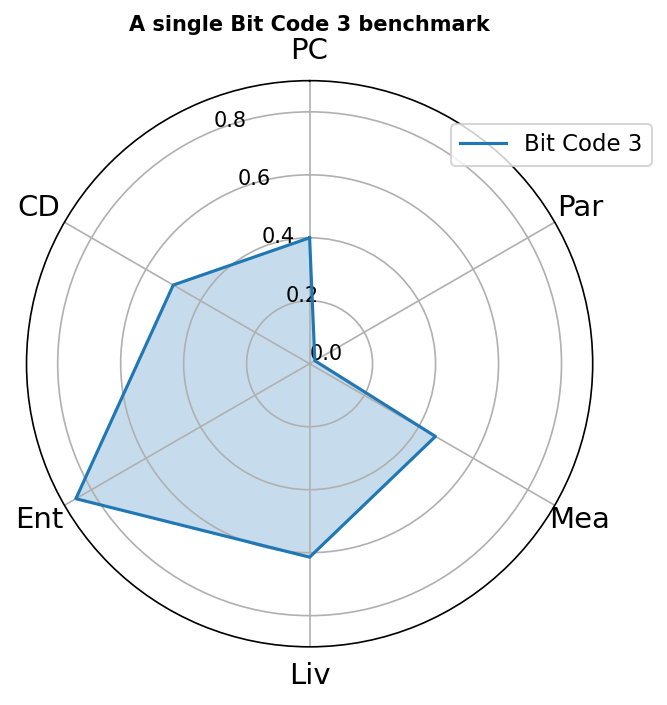

In [15]:
bitc_features = [
    supermarq.converters.compute_communication_with_qiskit(bitc_circuit),
    supermarq.converters.compute_depth_with_qiskit(bitc_circuit),
    supermarq.converters.compute_entanglement_with_qiskit(bitc_circuit),
    supermarq.converters.compute_liveness_with_qiskit(bitc_circuit),
    supermarq.converters.compute_measurement_with_qiskit(bitc_circuit),
    supermarq.converters.compute_parallelism_with_qiskit(bitc_circuit),
]
print(bitc_features)
print("--------------------------------------------------------------")
supermarq.plotting.plot_benchmark(
    ["A single Bit Code 3 benchmark", ["Bit Code 3"], [bitc_features]],
    spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
)

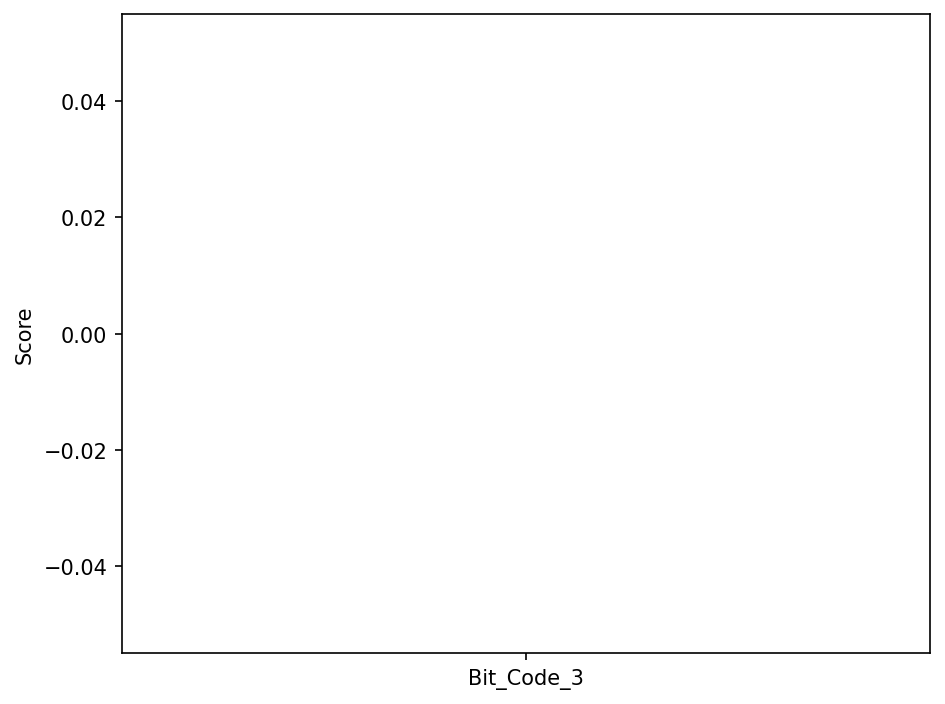

In [16]:
supermarq.plotting.plot_results([score], ["Bit_Code_3"])

In [23]:
benchmark_features = {}
benchmarks = [
    (supermarq.bit_code.BitCode(3, 3, [1, 0, 1]), "bit_code_3"),
    (supermarq.ghz.GHZ(5), "ghz5"),
    (supermarq.hamiltonian_simulation.HamiltonianSimulation(4), "hsim4"),
]
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(bitc_circuit),
        supermarq.converters.compute_depth_with_qiskit(bitc_circuit),
        supermarq.converters.compute_entanglement_with_qiskit(bitc_circuit),
        supermarq.converters.compute_liveness_with_qiskit(bitc_circuit),
        supermarq.converters.compute_measurement_with_qiskit(bitc_circuit),
        supermarq.converters.compute_parallelism_with_qiskit(bitc_circuit),]
print(benchmark_features)

{'bit_code_3': [0.4, 0.5, 0.8571428571428571, 0.5846153846153846, 0.46153846153846156, 0.019230769230769218], 'ghz5': [0.4, 0.5, 0.8571428571428571, 0.5846153846153846, 0.46153846153846156, 0.019230769230769218], 'hsim4': [0.4, 0.5, 0.8571428571428571, 0.5846153846153846, 0.46153846153846156, 0.019230769230769218]}


In [24]:
jobs = []
for benchmark, label in benchmarks:
    job = emulator.run(benchmark.qiskit_circuit(), shots=1000)
    jobs.append((label, job, benchmark))
jobs

[('bit_code_3',
  <supermarq.benchmarks.bit_code.BitCode at 0x79b70428e8f0>),
 ('ghz5',
  <supermarq.benchmarks.ghz.GHZ at 0x79b70428c250>),
 ('hsim4',
  <supermarq.benchmarks.hamiltonian_simulation.HamiltonianSimulation at 0x79b70428f340>)]

In [27]:
device_scores = {}
for label, job, benchmark in jobs:
    if job.status() == qiskit.providers.jobstatus.JobStatus.DONE:
        counts = job.result(0).get_counts()
        print(counts)
        score = benchmark.score(counts)
        print(score)
        device_scores[label] = score
    else:
        print(label, "not done!")

{'10001 11 11 11': 1000}
0.0
{'00000': 502, '11111': 498}
0.9999959999839999
{'0010': 2, '1101': 90, '1000': 5, '0110': 14, '1011': 85, '0111': 87, '0011': 13, '1110': 101, '1111': 533, '0001': 4, '1010': 25, '0101': 15, '1001': 14, '1100': 11, '0100': 1}
0.9993033905932742


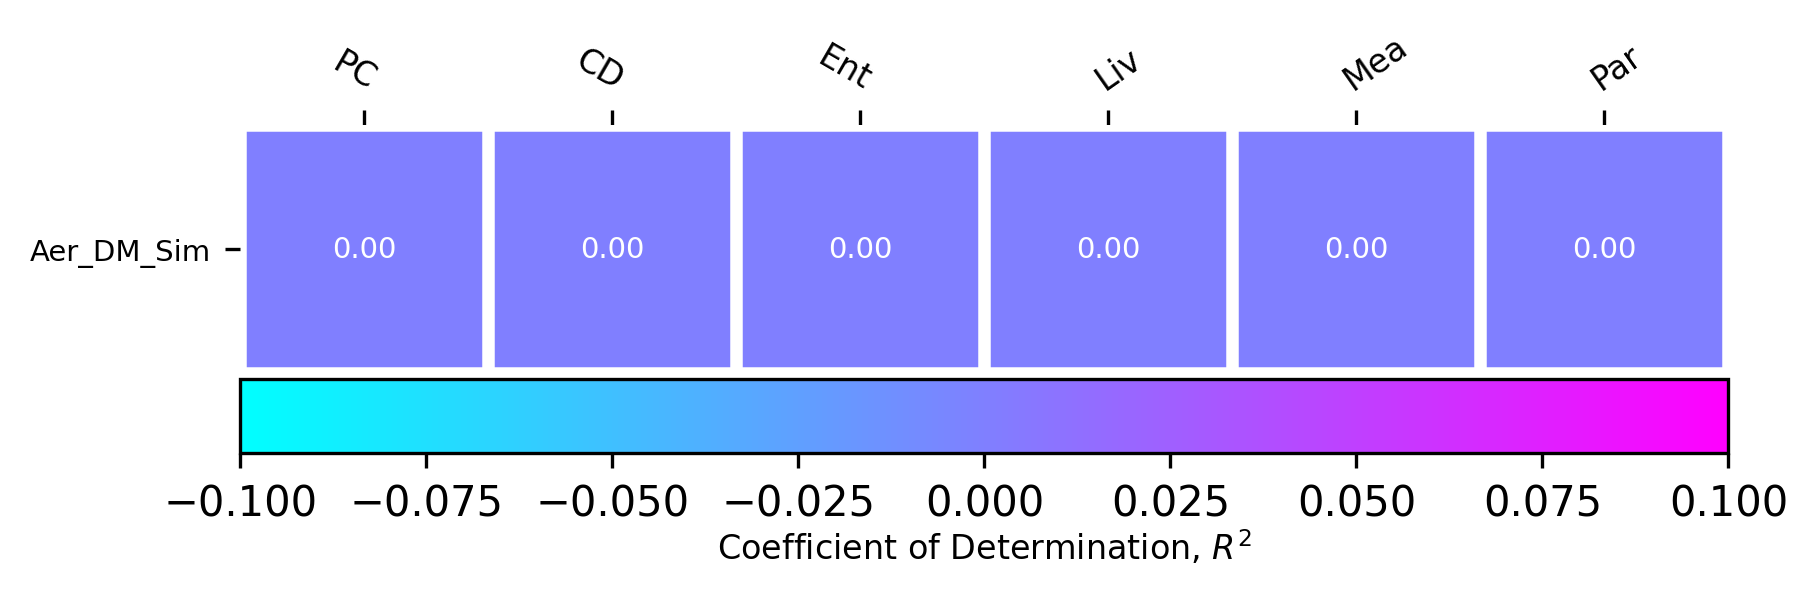

In [28]:
supermarq.plotting.plot_correlations(benchmark_features,
    device_scores,
    ["PC", "CD", "Ent", "Liv", "Mea", "Par"],
    device_name="Aer_DM_Sim",)